In [7]:
# Loading packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import joypy
import category_encoders as ce
import collections
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import InterclusterDistance
from scipy.cluster.vq import whiten
import riskfolio as rp
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

In [9]:
# Loading the dataset and visualizing summary statistics
df = pd.read_sas('a2z_insurance.sas7bdat', format='sas7bdat')
df.head(10)

,CustID,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
0,1.0,1985.0,1982.0,b'2 - High School',2177.0,1.0,1.0,380.97,0.39,375.85,79.45,146.36,47.01,16.89
1,2.0,1981.0,1995.0,b'2 - High School',677.0,4.0,1.0,-131.13,1.12,77.46,416.20,116.69,194.48,106.13
2,3.0,1991.0,1970.0,b'1 - Basic',2277.0,3.0,0.0,504.67,0.28,206.15,224.50,124.58,86.35,99.02
3,4.0,1990.0,1981.0,b'3 - BSc/MSc',1099.0,4.0,1.0,-16.99,0.99,182.48,43.35,311.17,35.34,28.34
4,5.0,1986.0,1973.0,b'3 - BSc/MSc',1763.0,4.0,1.0,35.23,0.90,338.62,47.80,182.59,18.78,41.45
5,6.0,1986.0,1956.0,b'2 - High School',2566.0,4.0,1.0,-24.33,1.00,440.75,18.90,114.80,7.00,7.67
6,7.0,1979.0,1943.0,b'2 - High School',4103.0,4.0,0.0,-66.01,1.05,156.92,295.60,317.95,14.67,26.34
7,8.0,1988.0,1974.0,b'2 - High School',1743.0,4.0,1.0,-144.91,1.13,248.27,397.30,144.36,66.68,53.23
8,9.0,1981.0,1978.0,b'3 - BSc/MSc',1862.0,1.0,1.0,356.53,0.36,344.51,18.35,210.04,8.78,9.89
9,10.0,1976.0,1948.0,b'3 - BSc/MSc',3842.0,1.0,0.0,-119.35,1.12,209.26,182.25,271.94,39.23,55.12


In [10]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
CustID,10296.0,NaN,NaN,NaN,5148.5,2972.34352,1.0,2574.75,5148.5,7722.25,10296.0
FirstPolYear,10266.0,NaN,NaN,NaN,1991.062634,511.267913,1974.0,1980.0,1986.0,1992.0,53784.0
BirthYear,10279.0,NaN,NaN,NaN,1968.007783,19.709476,1028.0,1953.0,1968.0,1983.0,2001.0
EducDeg,10279,4,b'3 - BSc/MSc',4799,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MonthSal,10260.0,NaN,NaN,NaN,2506.667057,1157.449634,333.0,1706.0,2501.5,3290.25,55215.0
GeoLivArea,10295.0,NaN,NaN,NaN,2.709859,1.266291,1.0,1.0,3.0,4.0,4.0
Children,10275.0,NaN,NaN,NaN,0.706764,0.455268,0.0,0.0,1.0,1.0,1.0
CustMonVal,10296.0,NaN,NaN,NaN,177.892605,1945.811505,-165680.42,-9.44,186.87,399.7775,11875.89
ClaimsRate,10296.0,NaN,NaN,NaN,0.742772,2.916964,0.0,0.39,0.72,0.98,256.2
PremMotor,10262.0,NaN,NaN,NaN,300.470252,211.914997,-4.11,190.59,298.61,408.3,11604.42


Data Understanding

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10296 entries, 0 to 10295
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CustID         10296 non-null  float64
 1   FirstPolYear   10266 non-null  float64
 2   BirthYear      10279 non-null  float64
 3   EducDeg        10279 non-null  object 
 4   MonthSal       10260 non-null  float64
 5   GeoLivArea     10295 non-null  float64
 6   Children       10275 non-null  float64
 7   CustMonVal     10296 non-null  float64
 8   ClaimsRate     10296 non-null  float64
 9   PremMotor      10262 non-null  float64
 10  PremHousehold  10296 non-null  float64
 11  PremHealth     10253 non-null  float64
 12  PremLife       10192 non-null  float64
 13  PremWork       10210 non-null  float64
dtypes: float64(13), object(1)
memory usage: 1.1+ MB


The data contains 14 columns with information on education, birth year, salary, family and information about the amount paid by types of insurance products

In [12]:
cols = ['EducDeg']
df[cols].apply(pd.Series.value_counts)

,EducDeg
EducDeg,
b'3 - BSc/MSc',4799
b'2 - High School',3510
b'1 - Basic',1272
b'4 - PhD',698


The only categorical variable of the dataset is the Education Degree which is divided into 4 categories: BSc/MSc (bachelor or masters), High School, Basic and PhD. Most of the insurance clients have a master or a bachelor degree, while PhD students are less frequent.

In [14]:
# Check missing values
print(df.isnull().sum())

CustID             0
FirstPolYear      30
BirthYear         17
EducDeg           17
MonthSal          36
GeoLivArea         1
Children          21
CustMonVal         0
ClaimsRate         0
PremMotor         34
PremHousehold      0
PremHealth        43
PremLife         104
PremWork          86
dtype: int64


Almost all features present missing values except “CustMonVal”, “ClaimsRate” and “PremHousehold”.

In [15]:
# Exploration of categorical variables (checking unknown categories)

#Cross Table of Education Degree and Monthly Salary
table1 = pd.crosstab(index=df['EducDeg'], columns=df['MonthSal']).T


#Cross Table of Education Degree and GeoLivArea
table2 = pd.crosstab(index=df['EducDeg'], columns=df['GeoLivArea']).T
table2

#Cross Table of GeoLivArea and Monthly Salary
table3 = pd.crosstab(index=df['GeoLivArea'], columns=df['MonthSal'])
table3

MonthSal,333.0,334.0,335.0,336.0,340.0,341.0,342.0,344.0,346.0,348.0,...,4857.0,4869.0,4872.0,4883.0,4897.0,4904.0,4995.0,5021.0,34490.0,55215.0
GeoLivArea,,,,,,,,,,,,,,,,,,,,,
1.0,0,0,1,1,1,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
2.0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
3.0,1,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4.0,1,0,1,0,0,2,1,1,0,0,...,1,1,1,2,1,0,0,0,1,1


In [17]:
table1

EducDeg,b'1 - Basic',b'2 - High School',b'3 - BSc/MSc',b'4 - PhD'
MonthSal,,,,
333.0,1,2,0,0
334.0,0,1,0,0
335.0,2,1,0,0
336.0,1,0,0,0
340.0,1,0,0,0
...,...,...,...,...
4904.0,0,0,1,0
4995.0,0,0,1,0
5021.0,0,1,0,0


<Axes: xlabel='GeoLivArea'>

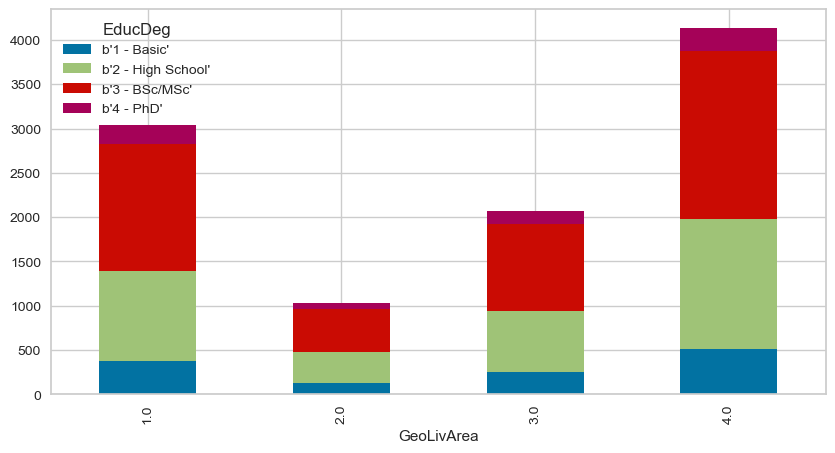

In [16]:
# Visualization

#Education Degree and GeoLivArea
table2.plot(kind="bar", figsize=(10,5), stacked=True)

array([[<Axes: title={'center': 'CustID'}>,
        <Axes: title={'center': 'FirstPolYear'}>,
        <Axes: title={'center': 'BirthYear'}>,
        <Axes: title={'center': 'MonthSal'}>],
       [<Axes: title={'center': 'GeoLivArea'}>,
        <Axes: title={'center': 'Children'}>,
        <Axes: title={'center': 'CustMonVal'}>,
        <Axes: title={'center': 'ClaimsRate'}>],
       [<Axes: title={'center': 'PremMotor'}>,
        <Axes: title={'center': 'PremHousehold'}>,
        <Axes: title={'center': 'PremHealth'}>,
        <Axes: title={'center': 'PremLife'}>],
       [<Axes: title={'center': 'PremWork'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

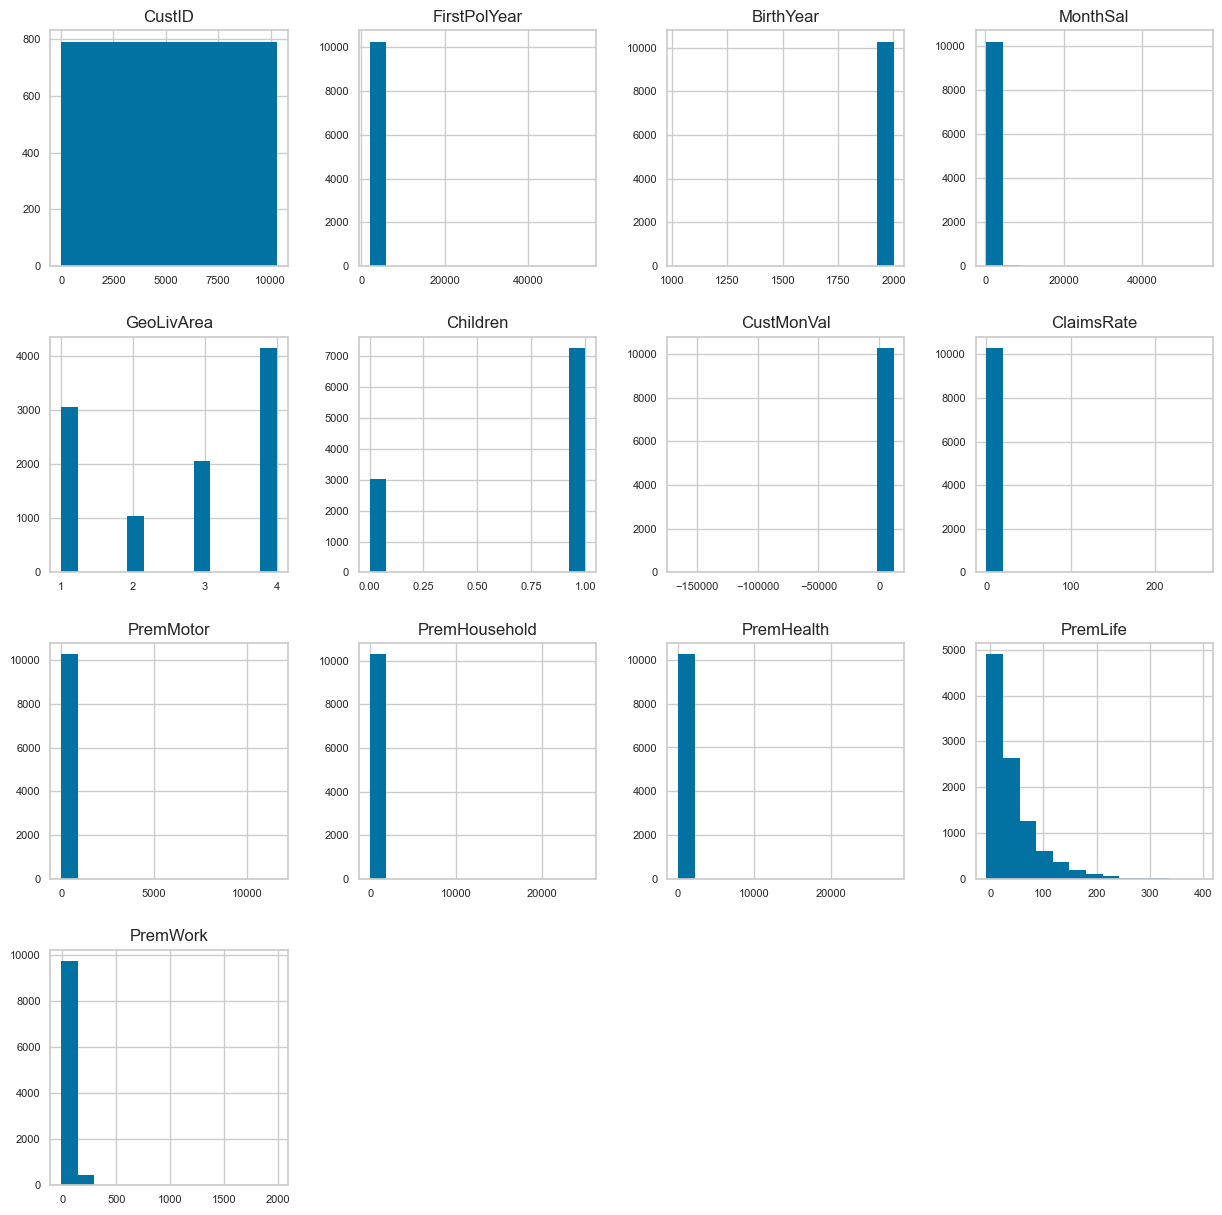

In [19]:
# HISTOGRAM (ALL NUMERIC VARIABLES)

# Identify all numeric variables in the dataset

numerical=df.select_dtypes(include=[np.number]).columns.tolist()

df[numerical].hist(bins=13, figsize=(15, 15), layout=(4, 4), xlabelsize=8, ylabelsize=8)

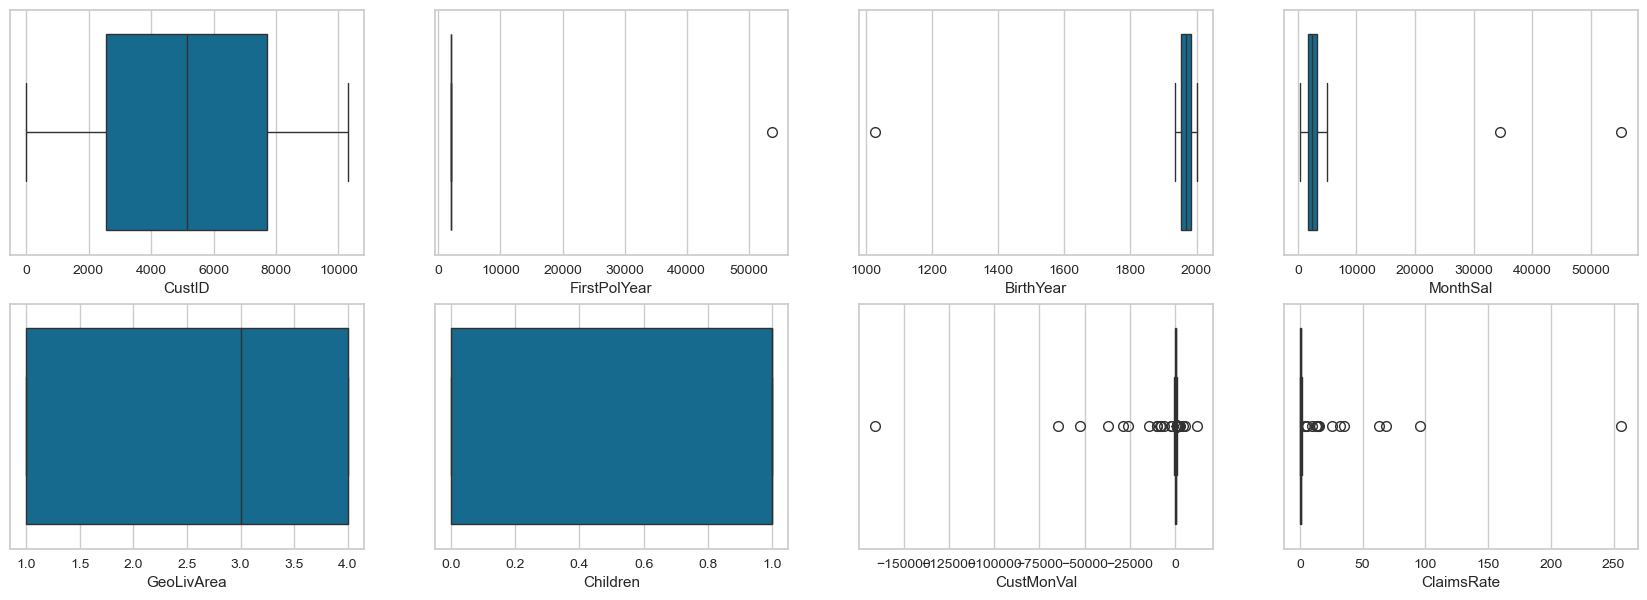

In [20]:
# Do boxplots on all numeric variables
fig, ax = plt.subplots(2, 4, figsize=(21, 7))
for var, subplot in zip(df[numerical], ax.flatten()):
    sns.boxplot(x=df[var], ax=subplot)

the boxplots for the variables Monthly Salary, Customer Monetary Value, and Claims Rate show notable variability, with some data points appearing far from the central range. However, given the real-world meaning of these variables, these values were considered valid and not treated as outliers.

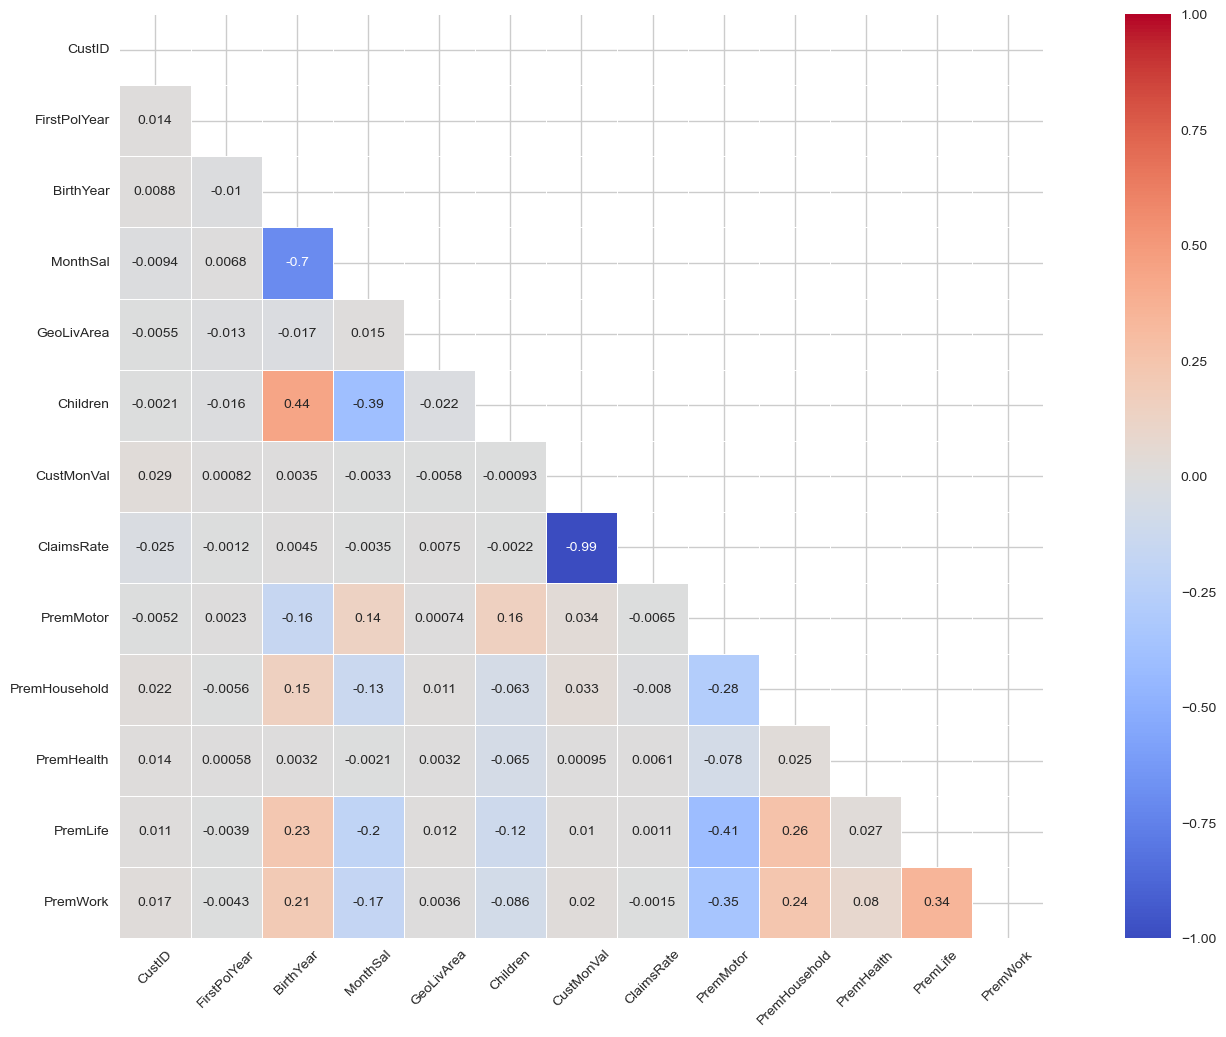

In [22]:
#Pearson Correlation only for numerical
corr = df[numerical].corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)]= True

f, ax = plt.subplots(figsize=(21, 12))
heatmap = sns.heatmap(corr,
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      vmin = -1,
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': 10})

#add the column names as labels
ax.set_yticklabels(corr.columns, rotation = 0)
ax.set_xticklabels(corr.columns, rotation = 45)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

Data Preparation

In [23]:
# Create a modeling dataset from the original dataset
X = df.copy(deep=True)

In [24]:
# Drop ID

X.drop("CustID", axis=1, inplace=True)

#Birth Year (1028)

X.drop(X.index[X['BirthYear'] == 1028.00], inplace = True)

#First Pol Year (53784)

X.drop(X.index[X['FirstPolYear'] == 53784.00], inplace = True)

In [25]:
#Missing Values

#FirstPolYear
imp = SimpleImputer(missing_values=np.nan, strategy='median')
X['FirstPolYear'] = imp.fit_transform(X['FirstPolYear'].values.reshape(-1,1))[:,0]

#BirthYear
imp = SimpleImputer(missing_values=np.nan, strategy='median')
X['BirthYear'] = imp.fit_transform(X['BirthYear'].values.reshape(-1,1))[:,0]

#Educational Degree
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
X['EducDeg'] = imp.fit_transform(X['EducDeg'].values.reshape(-1,1))[:,0]

#Monthly Salary 
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X['MonthSal'] = imp.fit_transform(X['MonthSal'].values.reshape(-1,1))[:,0]

#GeoLivArea
X = X.dropna(subset=['GeoLivArea'], how='all')

#Children
X['Children'] = X['Children'].fillna(0)

#PremMotor
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X['PremMotor'] = imp.fit_transform(X['PremMotor'].values.reshape(-1,1))[:,0]

#PremHealth
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X['PremHealth'] = imp.fit_transform(X['PremHealth'].values.reshape(-1,1))[:,0]

#PremWork
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X['PremWork'] = imp.fit_transform(X['PremWork'].values.reshape(-1,1))[:,0]

#PremLife
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X['PremLife'] = imp.fit_transform(X['PremLife'].values.reshape(-1,1))[:,0]

In [26]:
#Bin monthly salary

binsInterval = [0, 1000, 2000, 3000, 4000, 5000, 60000] # Create bins interval based on distribution/quartiles
intervalLabels = ['(0, 1000]', '(1000, 2000]',  '(2000, 3000]', '(3000, 4000]', '(4000, 5000]', '(>5000]']
X['MonthSal_binned'] = pd.cut(X['MonthSal'], bins = binsInterval, labels=intervalLabels)

# Drop Monthly Salary

X.drop("MonthSal", axis=1, inplace=True)

In [27]:
#Transforming the Educational Degree into numerical categories
for i in range(len(X['EducDeg'].values)):
    if X['EducDeg'].values[i] == b'2 - High School':
        X['EducDeg'].values[i] = '2'
    elif X['EducDeg'].values[i] == b'1 - Basic':
        X['EducDeg'].values[i] = '1'
    elif X['EducDeg'].values[i] == b'3 - BSc/MSc':
        X['EducDeg'].values[i] = '3'
    else:
        X['EducDeg'].values[i] = '4'   
        
X = X.astype({'EducDeg':'float'})


In [28]:
#Econding MonthlySal_Binned

cols = ['MonthSal_binned']
ce_one_hot = ce.OneHotEncoder(cols = cols, use_cat_names=True)
X = ce_one_hot.fit_transform(X)

In [29]:
#Checking Missing Values 
print(X.isnull().sum())

#Checking Variables' type
X.info()

FirstPolYear                    0
BirthYear                       0
EducDeg                         0
GeoLivArea                      0
Children                        0
CustMonVal                      0
ClaimsRate                      0
PremMotor                       0
PremHousehold                   0
PremHealth                      0
PremLife                        0
PremWork                        0
MonthSal_binned_(0, 1000]       0
MonthSal_binned_(1000, 2000]    0
MonthSal_binned_(2000, 3000]    0
MonthSal_binned_(3000, 4000]    0
MonthSal_binned_(4000, 5000]    0
MonthSal_binned_(>5000]         0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 10293 entries, 0 to 10295
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   FirstPolYear                  10293 non-null  float64
 1   BirthYear                     10293 non-null  float64
 2   EducDeg                       

In [30]:
# Get a copy of the dataframe before normalization for results' analysis
X_beforeNorm = X.copy(deep=True)

In [31]:
# Normalize all columns
# MinMax scaler returns an array, so the dataframe must be recreated
X = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(X.values), columns=X.columns,index=X.index)

Analyze Principal Components

In [32]:
# Let's use PCA to visualize with only two components
pca2 = PCA(n_components = 2)
pca2.fit(X)
X_pca2 = pca2.transform(X)
print(X_pca2.shape)

(10293, 2)


In [33]:
# Fit the PCA algorithm to data 
pca = PCA().fit(X)

# Show the variance per component
pcaevr = ['{:f}'.format(item) for item in pca.explained_variance_ratio_]
pcaDF = pd.DataFrame({'Component': range(1, len(X.columns)+1),
                      'Variance explained': pcaevr,
                      'Cumulative variance explained': np.cumsum(pca.explained_variance_ratio_)})
pcaDF

,Component,Variance explained,Cumulative variance explained
0,1,0.296222,0.296222
1,2,0.229702,0.525924
2,3,0.131837,0.657762
3,4,0.108166,0.765928
4,5,0.073458,0.839385
5,6,0.056082,0.895467
6,7,0.049838,0.945305
7,8,0.040020,0.985325
8,9,0.007495,0.992820
9,10,0.005979,0.998799


It could be inferred that the number of components that has a variance explained make the highest point between 7 and 9 dimensions when compared to 17 of all datasets.

Text(0, 0.5, 'Variance explained')

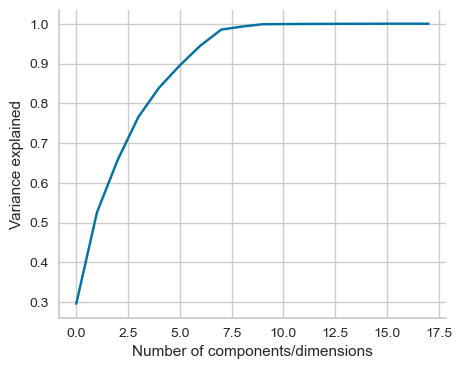

In [34]:
# Plot the cumulative explained variance

# Draw
fig , ax = plt.subplots(figsize=(5, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))

# Decoration
sns.despine()
plt.xlabel('Number of components/dimensions')
plt.ylabel('Variance explained')

Modeling - K-Means - 7 Components

In [39]:
# Apply the dimension reduction to the dataset (for 7 components)
pca_reduced = PCA(n_components = 7)
pca_reduced.fit(X)
X_pca_reduced = pca_reduced.transform(X) 
print(X_pca_reduced.shape)

(10293, 7)


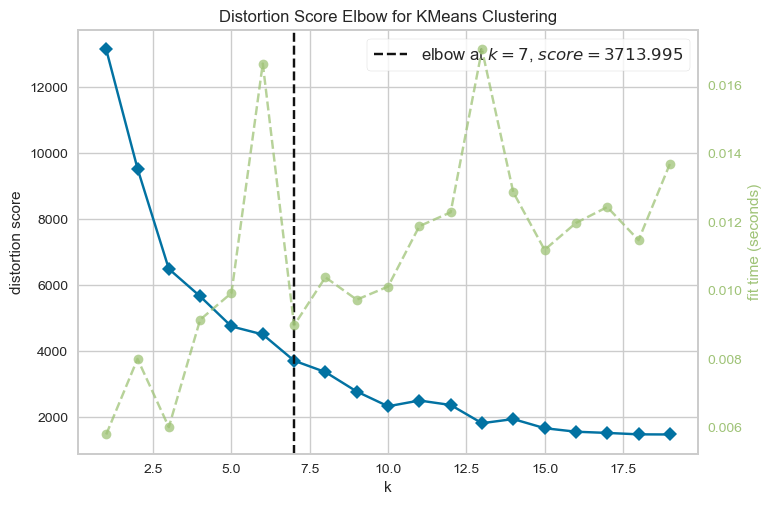

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [40]:
# Apply the Elbow method to select K
km = KMeans()
visualizer = KElbowVisualizer(km, k=(1,20), random_state=123)
visualizer.fit(X_pca_reduced)
visualizer.show() 

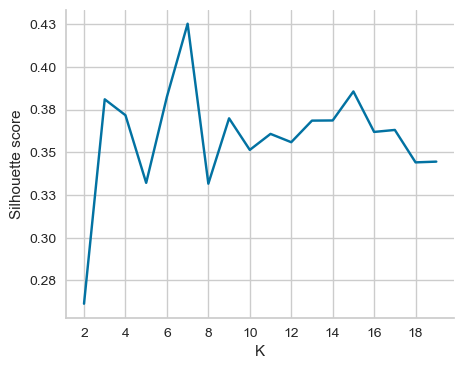

In [41]:
sil = []

for k in range(2, 20):
  km = KMeans(n_clusters = k, random_state=123).fit(X)
  labels = km.labels_
  sil.append(silhouette_score(X, labels, metric = 'euclidean'))


# Show Results
# Draw
fig , ax = plt.subplots(figsize=(5, 4))
plt.plot(range(2, 20), sil, 'bx-')
# Decoration
sns.despine()
fmt = "{x:,.2f}"
tick = ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
plt.xlabel('K')
plt.ylabel('Silhouette score')
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

In [42]:
# Apply the K-Means for K=7 and K = 6
K=7
K1=6
kmeans = KMeans(n_clusters=K, random_state=123)
kmeans1 = KMeans(n_clusters=K1, random_state=123)

allDistances = kmeans.fit_transform(X_pca_reduced)
allDistances1 = kmeans1.fit_transform(X_pca_reduced)

y_kmeans = kmeans.predict(X_pca_reduced)
y_kmeans1 = kmeans1.predict(X_pca_reduced)

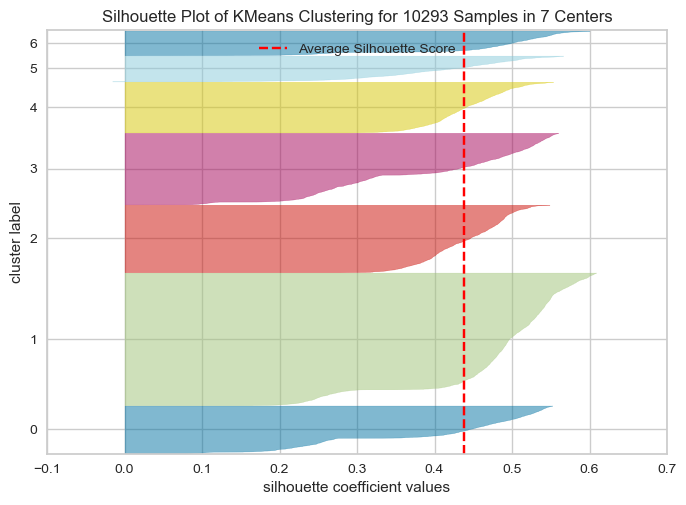

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 10293 Samples in 7 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [43]:
# Visualize Silhouette for K=7
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X_pca_reduced)
visualizer.show()

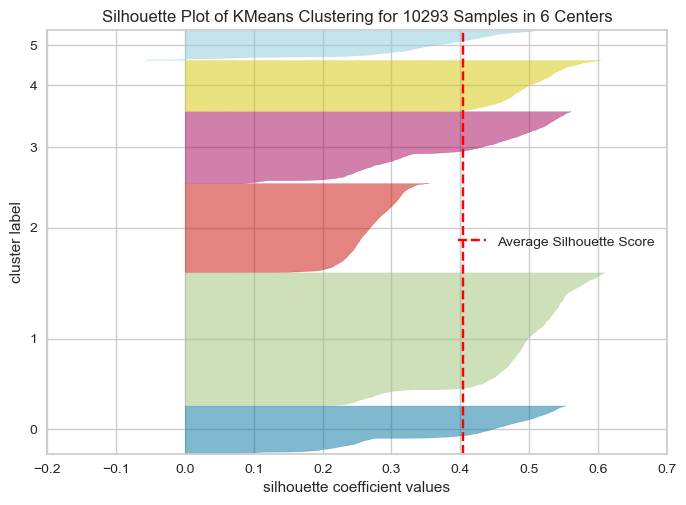

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 10293 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [44]:
# Visualize Silhouette for K=6
visualizer1 = SilhouetteVisualizer(kmeans1, colors='yellowbrick')
visualizer1.fit(X_pca_reduced)
visualizer1.show()

Text(0, 0.5, 'Frequency in cluster')

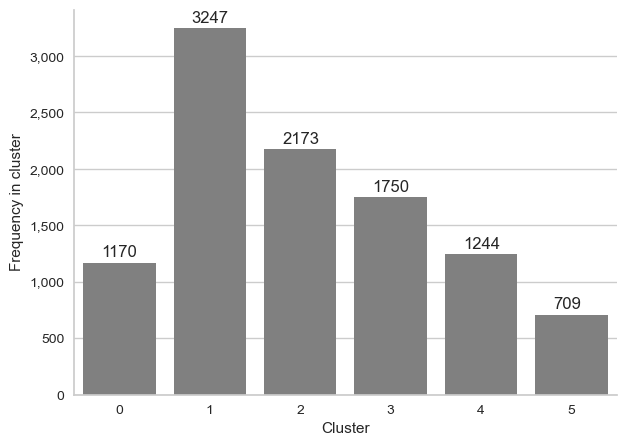

In [45]:
# Plot clusters cardinality (K = 6)

# Count observations per cluster
freqByCluster1 = X_beforeNorm.groupby(y_kmeans1).size()

# Draw
fig, ax = plt.subplots(figsize=(7,5))
g = sns.countplot(x=y_kmeans1, color='grey')

# Decoration
fmt = "{x:,.0f}"
tick = ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
for index,data in enumerate(freqByCluster1):
    plt.text(x=index-0.2 , y=data+50 , s=f"{data}")
sns.despine()

plt.xlabel("Cluster")
plt.ylabel("Frequency in cluster")

Text(0, 0.5, 'Frequency in cluster')

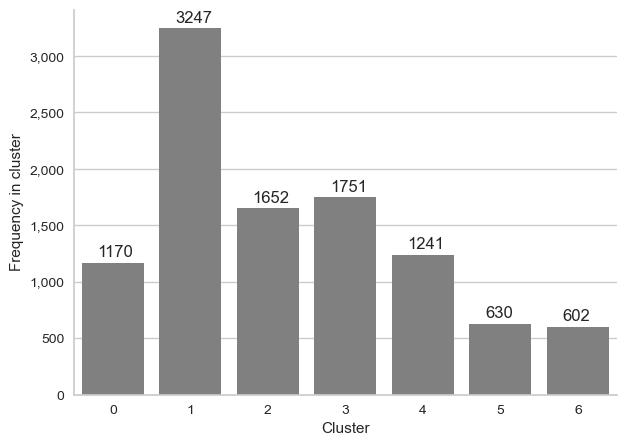

In [46]:
# Plot clusters cardinality (K = 7)

# Count observations per cluster
freqByCluster = X_beforeNorm.groupby(y_kmeans).size()

# Draw
fig, ax = plt.subplots(figsize=(7,5))
g = sns.countplot(x=y_kmeans, color='grey')

# Decoration
fmt = "{x:,.0f}"
tick = ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
for index,data in enumerate(freqByCluster):
    plt.text(x=index-0.2 , y=data+50 , s=f"{data}")
sns.despine()

plt.xlabel("Cluster")
plt.ylabel("Frequency in cluster")


Given these results, 7 clusters were applied to the dataset since the data seemed, globally, more balanced than using 6 clusters.

In [48]:
# Create a dataframe with the weights per component
wheightsDF = pd.DataFrame(pca.components_,columns=X.columns)
wheightsDF

,FirstPolYear,BirthYear,EducDeg,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,"MonthSal_binned_(0, 1000]","MonthSal_binned_(1000, 2000]","MonthSal_binned_(2000, 3000]","MonthSal_binned_(3000, 4000]","MonthSal_binned_(4000, 5000]",MonthSal_binned_(>5000]
0,9.059742e-03,-3.239974e-01,2.783329e-02,2.778169e-02,-5.412505e-01,-4.669416e-05,4.662458e-05,-1.130090e-03,-2.748482e-04,6.738998e-04,-1.779971e-03,-7.150952e-04,-0.026387,-0.394292,-0.264261,0.606951,0.077803,0.000185
1,-1.333555e-03,-1.527086e-01,5.746144e-02,-8.037013e-03,7.581605e-02,1.832912e-04,-3.607452e-04,9.004008e-03,-3.949971e-03,-1.426260e-03,-5.208596e-02,-1.058160e-02,-0.026276,-0.625226,0.750837,-0.096323,-0.002957,-0.000055
2,-5.686179e-03,1.241717e-02,-1.805826e-02,9.993016e-01,6.707430e-03,-1.354819e-04,1.908566e-04,-3.957684e-05,5.038331e-04,3.706431e-05,5.108241e-03,5.389334e-04,0.007663,0.003893,0.014916,-0.022289,-0.004342,0.000159
3,-3.398596e-03,-1.583247e-02,7.119034e-02,1.037698e-02,7.332300e-01,-1.091703e-04,2.576583e-05,7.657501e-03,-3.346980e-03,-1.421222e-03,-4.925377e-02,-8.603479e-03,-0.044808,-0.101468,-0.100254,0.571648,-0.324388,-0.000730
4,-2.474348e-02,2.494840e-01,-5.432561e-01,-1.666191e-02,7.682056e-02,5.903829e-04,-1.543785e-04,-1.710488e-02,1.250035e-02,1.108493e-03,1.706182e-01,3.112306e-02,0.651626,-0.370070,-0.197193,-0.067456,-0.017485,0.000579
5,9.977278e-01,-9.937097e-03,-4.878976e-02,4.872798e-03,2.628497e-02,-1.212437e-04,1.556296e-04,-8.231664e-04,-5.421885e-05,1.281193e-04,1.067093e-02,2.783766e-03,-0.010861,-0.007645,-0.005806,-0.006666,0.031120,-0.000143
6,-1.073838e-02,-1.895152e-01,4.429444e-01,1.119468e-02,3.234194e-01,-6.173652e-04,3.330422e-04,9.107695e-03,-6.458209e-03,8.273679e-04,-9.684111e-02,-1.435438e-02,0.179105,-0.250699,-0.339968,-0.217422,0.628931,0.000053
7,6.027389e-02,3.207060e-01,6.824522e-01,4.929868e-03,-2.183300e-01,-1.306122e-04,1.119613e-04,3.252264e-03,-2.795797e-03,4.114792e-04,-3.173055e-02,-7.273514e-03,0.451391,-0.041566,0.011764,-0.004902,-0.416364,-0.000324
8,-6.829577e-03,4.885338e-01,1.526479e-01,-5.265526e-04,9.779903e-03,-4.137202e-04,8.576710e-04,-3.115745e-02,1.132683e-02,-9.846910e-04,7.361621e-01,2.548271e-02,-0.299740,-0.134588,0.035912,0.147733,0.251262,-0.000580
9,1.174004e-03,6.562706e-01,-8.295827e-02,8.220421e-04,-6.758444e-02,-8.566536e-04,1.153113e-03,1.758318e-02,2.954994e-05,9.174185e-04,-6.411241e-01,3.980693e-03,-0.213607,-0.153117,-0.013122,0.147283,0.235674,-0.003111


In [49]:
# Study the weights of component 7
comp = abs(wheightsDF.iloc[6])  ## index 6 is component 7
comp = comp.sort_values(ascending=False)
comp

MonthSal_binned_(4000, 5000]    0.628931
EducDeg                         0.442944
MonthSal_binned_(2000, 3000]    0.339968
Children                        0.323419
MonthSal_binned_(1000, 2000]    0.250699
MonthSal_binned_(3000, 4000]    0.217422
BirthYear                       0.189515
MonthSal_binned_(0, 1000]       0.179105
PremLife                        0.096841
PremWork                        0.014354
GeoLivArea                      0.011195
FirstPolYear                    0.010738
PremMotor                       0.009108
PremHousehold                   0.006458
PremHealth                      0.000827
CustMonVal                      0.000617
ClaimsRate                      0.000333
MonthSal_binned_(>5000]         0.000053
Name: 6, dtype: float64

In [50]:
# Check the mean values of each cluster for top 30 relevant features
top_features = comp[:30].index

#Apply K =7
clustersMeanDF = pd.DataFrame(X_beforeNorm[top_features].groupby(y_kmeans).mean(),columns=top_features)
clustersMeanDF.transpose()

,0,1,2,3,4,5,6
"MonthSal_binned_(4000, 5000]",0.000000,0.000000,0.000000,0.000000,0.000000,0.001587,0.996678
EducDeg,2.417949,2.578072,2.546005,2.419189,2.594682,1.758730,2.578073
"MonthSal_binned_(2000, 3000]",0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Children,0.884615,0.880197,0.000000,0.892062,1.000000,0.769841,0.134551
"MonthSal_binned_(1000, 2000]",1.000000,0.000000,0.000000,0.999429,0.000000,0.000000,0.000000
"MonthSal_binned_(3000, 4000]",0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
BirthYear,1985.114530,1967.834617,1947.021186,1984.970303,1956.245770,1993.788889,1942.830565
"MonthSal_binned_(0, 1000]",0.000000,0.000000,0.000000,0.000000,0.000000,0.998413,0.000000
PremLife,51.012328,26.426528,43.876301,50.883161,31.150148,99.623333,37.261573
PremWork,51.852888,25.204825,41.150529,50.329454,32.597783,97.684569,40.413474


In [ ]:
Some insights:
🔹 Cluster 0 – Budget-Conscious Loyalists
Profile: Long-time, low-income customers with children and basic insurance usage.

Policy Suggestion: Affordable essential bundles (life + basic health + household). Emphasize loyalty rewards.

🔹 Cluster 1 – Premium Protection Seekers
Profile: Older, affluent professionals with high motor and health premiums.

Policy Suggestion: Offer comprehensive coverage with add-ons (e.g., critical illness, accident cover, full motor protection).

🔹 Cluster 2 – Senior Health Guardians
Profile: Older customers with strong health and household insurance.

Policy Suggestion: Focus on senior-friendly health plans, long-term care, and home protection.

🔹 Cluster 3 – Young Family Builders
Profile: Younger customers with children, high claim rates, and broad insurance use.

Policy Suggestion: Bundle family-focused plans — life, health, motor — with child & maternity add-ons.

🔹 Cluster 4 – Stable Coverage Planners
Profile: Middle-aged, middle-income customers with balanced premiums and steady behavior.

Policy Suggestion: Offer standard multi-line coverage with options to upgrade or plan for retirement.

🔹 Cluster 5 – High-Risk Heavy Users
Profile: Youngest group, low income, but very high insurance spending and usage.

Policy Suggestion: Provide modular, flexible plans with usage-based pricing. Include personal accident or digital asset insurance.

🔹 Cluster 6 – Minimalist Elder Policyholders
Profile: Oldest, low-income customers with low value and light usage.

Policy Suggestion: Simplified basic health and funeral coverage, with easy service channels.

In [51]:
kmeans = KMeans(n_clusters=7, random_state=123)
X["Kmeans_Cluster"] = kmeans.fit_predict(X)

In [52]:
X

,FirstPolYear,BirthYear,EducDeg,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,"MonthSal_binned_(0, 1000]","MonthSal_binned_(1000, 2000]","MonthSal_binned_(2000, 3000]","MonthSal_binned_(3000, 4000]","MonthSal_binned_(4000, 5000]",MonthSal_binned_(>5000],Kmeans_Cluster
0,0.458333,0.712121,0.333333,0.000000,1.0,0.935260,0.001522,0.032731,0.006148,0.005251,0.133259,0.014440,0.0,0.0,1.0,0.0,0.0,0.0,1
1,0.291667,0.909091,0.333333,1.000000,1.0,0.932376,0.004372,0.007027,0.019551,0.004202,0.497113,0.059044,1.0,0.0,0.0,0.0,0.0,0.0,5
2,0.708333,0.530303,0.000000,0.666667,0.0,0.935957,0.001093,0.018113,0.011921,0.004481,0.230323,0.055491,0.0,0.0,1.0,0.0,0.0,0.0,1
3,0.666667,0.696970,0.666667,1.000000,1.0,0.933019,0.003864,0.016074,0.004711,0.011080,0.104466,0.020163,0.0,1.0,0.0,0.0,0.0,0.0,0
4,0.500000,0.575758,0.666667,1.000000,1.0,0.933313,0.003513,0.029524,0.004888,0.006532,0.063607,0.026716,0.0,1.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10291,0.416667,0.212121,1.000000,0.333333,0.0,0.933114,0.003747,0.034272,0.004953,0.006222,0.041401,0.013385,0.0,0.0,0.0,1.0,0.0,0.0,4
10292,0.125000,0.257576,0.000000,0.666667,0.0,0.941031,0.000000,0.011861,0.044211,0.005141,0.049075,0.058545,0.0,0.0,1.0,0.0,0.0,0.0,1
10293,0.833333,0.621212,0.666667,0.000000,1.0,0.936067,0.000820,0.035124,0.008271,0.005106,0.048532,0.008442,0.0,0.0,1.0,0.0,0.0,0.0,1
10294,0.291667,0.636364,0.000000,0.333333,1.0,0.934523,0.002537,0.016600,0.011390,0.007091,0.174932,0.062433,0.0,1.0,0.0,0.0,0.0,0.0,0


In [75]:
def assign_segment(cluster):
    if cluster == 0:
        return "Budget-Conscious Loyalists"  
    elif cluster == 1:
        return "Premium Protection Seekers"  
    elif cluster == 2:
        return "Senior Health Guardians"
    elif cluster == 3:
        return "Young Family Builders"
    elif cluster == 4:
        return " Stable Coverage Planners"
    elif cluster == 5:
        return "High-Risk Heavy Users"
    elif cluster == 6:
        return " Minimalist Elder Policyholders"
X["Customer_Segment"] = X["Kmeans_Cluster"].apply(assign_segment)
print("Labeled dataset saved successfully!")

Labeled dataset saved successfully!


In [76]:
X

,FirstPolYear,BirthYear,EducDeg,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,"MonthSal_binned_(0, 1000]","MonthSal_binned_(1000, 2000]","MonthSal_binned_(2000, 3000]","MonthSal_binned_(3000, 4000]","MonthSal_binned_(4000, 5000]",MonthSal_binned_(>5000],Kmeans_Cluster,Customer_Segment
0,0.458333,0.712121,0.333333,0.000000,1.0,0.935260,0.001522,0.032731,0.006148,0.005251,0.133259,0.014440,0.0,0.0,1.0,0.0,0.0,0.0,1,Premium Protection Seekers
1,0.291667,0.909091,0.333333,1.000000,1.0,0.932376,0.004372,0.007027,0.019551,0.004202,0.497113,0.059044,1.0,0.0,0.0,0.0,0.0,0.0,5,High-Risk Heavy Users
2,0.708333,0.530303,0.000000,0.666667,0.0,0.935957,0.001093,0.018113,0.011921,0.004481,0.230323,0.055491,0.0,0.0,1.0,0.0,0.0,0.0,1,Premium Protection Seekers
3,0.666667,0.696970,0.666667,1.000000,1.0,0.933019,0.003864,0.016074,0.004711,0.011080,0.104466,0.020163,0.0,1.0,0.0,0.0,0.0,0.0,0,Budget-Conscious Loyalists
4,0.500000,0.575758,0.666667,1.000000,1.0,0.933313,0.003513,0.029524,0.004888,0.006532,0.063607,0.026716,0.0,1.0,0.0,0.0,0.0,0.0,0,Budget-Conscious Loyalists
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10291,0.416667,0.212121,1.000000,0.333333,0.0,0.933114,0.003747,0.034272,0.004953,0.006222,0.041401,0.013385,0.0,0.0,0.0,1.0,0.0,0.0,4,Stable Coverage Planners
10292,0.125000,0.257576,0.000000,0.666667,0.0,0.941031,0.000000,0.011861,0.044211,0.005141,0.049075,0.058545,0.0,0.0,1.0,0.0,0.0,0.0,1,Premium Protection Seekers
10293,0.833333,0.621212,0.666667,0.000000,1.0,0.936067,0.000820,0.035124,0.008271,0.005106,0.048532,0.008442,0.0,0.0,1.0,0.0,0.0,0.0,1,Premium Protection Seekers
10294,0.291667,0.636364,0.000000,0.333333,1.0,0.934523,0.002537,0.016600,0.011390,0.007091,0.174932,0.062433,0.0,1.0,0.0,0.0,0.0,0.0,0,Budget-Conscious Loyalists


In [77]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10293 entries, 0 to 10295
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   FirstPolYear                  10293 non-null  float64
 1   BirthYear                     10293 non-null  float64
 2   EducDeg                       10293 non-null  float64
 3   GeoLivArea                    10293 non-null  float64
 4   Children                      10293 non-null  float64
 5   CustMonVal                    10293 non-null  float64
 6   ClaimsRate                    10293 non-null  float64
 7   PremMotor                     10293 non-null  float64
 8   PremHousehold                 10293 non-null  float64
 9   PremHealth                    10293 non-null  float64
 10  PremLife                      10293 non-null  float64
 11  PremWork                      10293 non-null  float64
 12  MonthSal_binned_(0, 1000]     10293 non-null  float64
 13  MonthS

In [78]:
x=X[['BirthYear','EducDeg','Children', 'MonthSal_binned_(0, 1000]',
       'MonthSal_binned_(1000, 2000]', 'MonthSal_binned_(2000, 3000]',
       'MonthSal_binned_(3000, 4000]', 'MonthSal_binned_(4000, 5000]',
       'MonthSal_binned_(>5000]','PremMotor', 'PremHousehold', 'PremHealth',
       'PremLife', 'PremWork','ClaimsRate']]

In [79]:
y=X[['Customer_Segment']]

In [80]:
y

,Customer_Segment
0,Premium Protection Seekers
1,High-Risk Heavy Users
2,Premium Protection Seekers
3,Budget-Conscious Loyalists
4,Budget-Conscious Loyalists
...,...
10291,Stable Coverage Planners
10292,Premium Protection Seekers
10293,Premium Protection Seekers
10294,Budget-Conscious Loyalists


In [81]:
from  sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=42,test_size=0.2,train_size=0.8)

In [82]:
from sklearn.ensemble import RandomForestClassifier
model =RandomForestClassifier()
model.fit(x_train,y_train)

D:\anaconda3\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [83]:
ypred = model.predict(x_test)
from sklearn.metrics import classification_report
fullreport = classification_report(ypred,y_test)

print(fullreport)

                                 precision    recall  f1-score   support

 Minimalist Elder Policyholders       1.00      1.00      1.00       109
       Stable Coverage Planners       1.00      1.00      1.00       356
     Budget-Conscious Loyalists       1.00      1.00      1.00       603
          High-Risk Heavy Users       1.00      0.99      1.00       133
     Premium Protection Seekers       1.00      1.00      1.00       606
        Senior Health Guardians       0.82      0.60      0.69       205
          Young Family Builders       0.20      0.45      0.28        47

                       accuracy                           0.95      2059
                      macro avg       0.86      0.86      0.85      2059
                   weighted avg       0.96      0.95      0.95      2059



In [84]:
import numpy as np
inputdata=(2001,1,1,1,0,0,0,0,0,117,492.28,220.79,99.62,97.68,0.72)
inputdataarray=np.asarray(inputdata)
inputdatareshape=inputdataarray.reshape(1,-1)
prediction=model.predict(inputdatareshape)
print("\n🧠 Predicted Customer Segment:", *prediction)


🧠 Predicted Customer Segment: High-Risk Heavy Users


D:\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [85]:
import pickle
with open('customersegmentation.pkl','wb')as file:
    pickle.dump(model,file)